# RNN-based classification of neutrino detection signals

## 1. Load libraries and classes

### External libraries

In [94]:
import numpy as np
import pandas as pd
import importlib
import torch
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
import time
import matplotlib.pyplot as plt
import ast

In [95]:
!pip install thop
from thop import profile  # For estimating number of flops for a given RNN model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
# use GPU for computation if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### For Google Colab environment

In [97]:
# IF RUNNING IN GOOGLE COLAB:
# Connect to Google Drive (so we do not have to download the data files each time the runtime resets)
from google.colab import drive
drive.mount("/content/gdrive")

# Where to fetch data files
data_path = "/content/gdrive/MyDrive/Colab Notebooks/Data/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [98]:
# IF RUNNING IN GOOGLE COLAB:
# Copy class files (.py files) to the local Notebook folder in Colab, so we can import them below
!cp "/content/gdrive/MyDrive/Colab Notebooks/Model_RNN.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/Model_LSTM.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/Model_GRU.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/Model_Continuous_LSTM.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/Trainer.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/RNNBinaryClassifier.py" .
!cp "/content/gdrive/MyDrive/Colab Notebooks/BinaryClassificationPreprocessor.py" .

#### When running locally

In [99]:
# Fetch data directly from the hard drive
#data_path = "C:/DataProject15ECT/ARIANNA_100_1CH/"

### Definition of different RNN models

In [100]:
# Make sure we get the latest versions
importlib.reload(importlib.import_module("Model_RNN"))
importlib.reload(importlib.import_module("Model_LSTM"))
importlib.reload(importlib.import_module("Model_GRU"))
importlib.reload(importlib.import_module("Model_Continuous_LSTM"))

from Model_RNN import Model_RNN
from Model_LSTM import Model_LSTM
from Model_GRU import Model_GRU
from Model_Continuous_LSTM import Model_Continuous_LSTM

print("Loaded.")

Loaded.


### Modules for mini-batch training, data preprocessing and binary classification

In [101]:
# Make sure we get the latest versions
importlib.reload(importlib.import_module("Trainer"))
importlib.reload(importlib.import_module("BinaryClassificationPreprocessor"))
importlib.reload(importlib.import_module("RNNBinaryClassifier"))

from Trainer import Trainer
from BinaryClassificationPreprocessor import BinaryClassificationPreprocessor
from RNNBinaryClassifier import RNNBinaryClassifier
print("Loaded.")

Loaded.


### Helper functions

In [102]:
def save_result(df0, classifier):
    # Assumes that evaluation has been done for <classifier>
    df = pd.DataFrame()
    model = classifier.trainer.best_model
    df['Model'] = [str(model)]
    df['Parameters'] = [sum(p.numel() for p in model.parameters() if p.requires_grad)]
    ns, nr = classifier.calculate_signal_eff_noise_red()
    df['ns'] = [ns]
    df['nr'] = [nr]
    return pd.concat([df0, df], ignore_index=True)

def read_results(filename):
  df = pd.read_csv(filename)
  for i in range(len(df)):
      df.at[i, "ns"] = np.array(ast.literal_eval(df.iloc[i].ns))
      df.at[i, "nr"] = np.array(ast.literal_eval(df.iloc[i].nr))
  if 'index' in df.columns:
    df = df.drop(columns='index')   
  return df.sort_values('Parameters')

def plot_results_comparison(df, xlim, ylim):
    for i in range(len(df)):
        plt.plot(df.iloc[i].ns, df.iloc[i].nr, label=df.iloc[i].Parameters)
    if xlim != None:
        plt.xlim(xlim)
    if ylim != None:
        plt.ylim(ylim)
    plt.xlabel("Signal efficiency")
    plt.ylabel("log10(noise reduction)")
    plt.grid()
    plt.legend(title="# parameters")
    plt.show()

# Transform the original data into a continous input with labels for each datapoint
def create_continuous_input(signal_events, noise_events, start_event=40, end_event=80):
  print("Input shape:", signal_events.shape, noise_events.shape)
  N_FEATURES = signal_events.shape[1]
  WINDOW_LENGTH = signal_events.shape[2]  # Must be the same for both signal events and noise events
  N_SERIES = len(signal_events) + len(noise_events)
  N_STEPS = N_SERIES * WINDOW_LENGTH

  series = []
  labels = []
  for i in range(len(signal_events)):
      series.append(signal_events[i,:,:])

      # Add corresponding labels for each timestep of the signal event
      labels.append(np.concatenate((np.zeros(start_event),                  # noise part
                                    np.ones(end_event - start_event),       # signal part
                                    np.zeros(WINDOW_LENGTH - end_event))))  # noise part

  for i in range(len(noise_events)):
      series.append(noise_events[i,:,:])
      labels.append(np.zeros(WINDOW_LENGTH))

  print("Series size:", len(series), len(series[0]), len(series[0][0]))

  p = np.random.permutation(N_SERIES)
  X_data = np.zeros((N_STEPS, N_FEATURES))
  y_data = np.zeros(N_STEPS)
  pos = 0
  for i in range(len(series)):
      j = p[i]   # Random order when concatenating
      L = series[j].shape[1]
      for ch in range(N_FEATURES):
          X_data[pos:pos+L,ch] = series[j][ch]
      y_data[pos:pos+L] = labels[j]
      pos += L
      
  print("Final shape of input and labels:", X_data.shape, y_data.shape)
  del series
  del labels
  return X_data, y_data

## 2. Univariate batch processing (ARIANNA 1CH 100 dataset)

### Data preparation

In [11]:
# Load ARIANNA 100 timesteps 1 channel dataset
# ** Note that path must be set according to the current enviroment **
fullpath = data_path + "ARIANNA_100_1CH/"
noise = np.load(fullpath + "trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,6):
    noise = np.vstack((noise,np.load(fullpath + f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
signal = np.load(fullpath + "trimmed100_data_signal_3.6SNR_1ch_0000.npy")
signal = signal.reshape(signal.shape[0], 1, signal.shape[1])
noise = noise.reshape(noise.shape[0], 1, noise.shape[1])
print("Signal events:", signal.shape)
print("Noise events:", noise.shape)

X_in = signal
Y_in = noise

Signal events: (99997, 1, 100)
Noise events: (600000, 1, 100)


In [ ]:
# Try pruning parts of each record - NOT IN USE currently
#X_in = X_in[:,:,30:60]
#Y_in = Y_in[:,:,30:60]
#print(X_in.shape, Y_in.shape)

### Model definition and training

In [12]:
# The results will be accumulated in df, only needed if gathering data for plotting
#df = pd.DataFrame()

In [13]:
pp = BinaryClassificationPreprocessor()
cl = RNNBinaryClassifier(device)

In [14]:
cl.load_data(pp.load_data_by_class(X_in, Y_in, val_ratio=0.2, test_ratio=0.2))

Process 1: using 99997 time series with 1 features, of length 100
Process 2: using 600000 time series with 1 features, of length 100
Before fit
After fit transform
1
2
After scaling
Preprocessed datasets:
Train: (419997, 1, 100), range [-437.88816123924704, 498.10948182767805]
Validation: (140000, 1, 100), range [-421.4879264509714, 269.84679904147333]
Test: (140000, 1, 100), range [-384.44117981753396, 443.3798553806822]


In [106]:
# For determining the number of FLOPS:
dropout = 0.0
model = Model_Continuous_LSTM(1, 1, 8, 1, dropout, device)
input = torch.randn(1, 100, 1).to(device)
macs, params = profile(model, inputs=(input, ))
print(macs)
print(params)

[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
42400.0
361.0



Number of trainable parameters in the model: 169
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[1/10] Training loss: 0.0316	 Validation loss: 0.0132
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[2/10] Training loss: 0.0125	 Validation loss: 0.0119
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[3/10] Training loss: 0.0111	 Validation loss: 0.0087
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[4/10] Training loss: 0.0102	 Validation loss: 0.0099
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[5/10] Training loss: 0.0096	 Validation loss: 0.0083
Best so far, saving
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[6/10] Training loss: 0.0092	 Validation loss: 0.0085
0...420...840...1260...1680...2100...2520...2940...3360...3780...
[7/10] Training loss: 0.0092	 Validation loss: 0.0080
Best so far, saving
0...420...

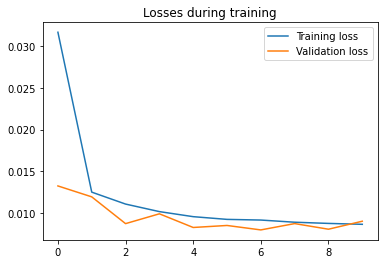

Training time: 125.12997436523438


In [17]:
# Define the model and start training
n_features = 1
output_dim = 1  
hidden_size = 6
n_hidden = 1
dropout = 0.0

model = Model_GRU(n_features, 1, hidden_size, n_hidden, dropout, device)
print("\nNumber of trainable parameters in the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))
t0 = time.time()
best_model = cl.train(model, n_features=n_features, n_epochs=10, lr=0.01, batch_size=100)
print("Training time:", time.time() - t0)

### Evaluation

In [18]:
cl.run_evaluation(batch_size=100)

In [19]:
r_value = 0.5
metrics, _ = cl.classify_with_threshold(r_value=r_value)
print("r_value:", r_value)
print("Accuracy:", metrics[0], "\nPrecision:", metrics[1][0], "\nRecall:", metrics[1][1], "\nF1:", metrics[1][2])

r_value: 0.5
Accuracy: 0.9976071428571428 
Precision: 0.9989447236180905 
Recall: 0.9844500569504284 
F1: 0.9916444267079042


Total signal events: 20193 Total noise events: 119807


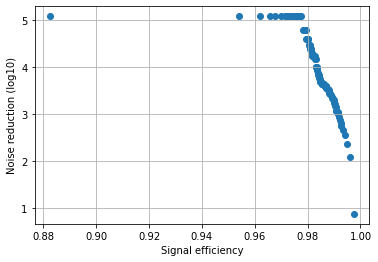

In [20]:
cl.plot_signal_eff_vs_noise_red()

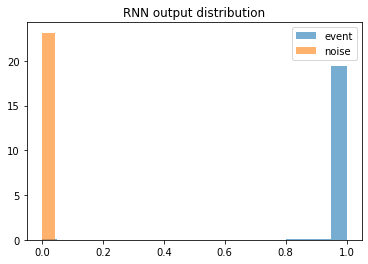

In [21]:
cl.plot_output_distribution()

In [22]:
# Gather results for later plotting
#df = save_result(df, cl)

In [ ]:
#df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/result_1CH_100.csv", index=False)

In [ ]:
#df

,Model,Parameters,ns,nr
3,"Model_GRU(\n (rnn): GRU(1, 2, batch_first=Tru...",33,"[0.9974626865671642, 0.9926865671641791, 0.991...","[0.45787153753962495, 1.3701433903723117, 1.61..."
1,"Model_GRU(\n (rnn): GRU(1, 4, batch_first=Tru...",89,"[0.9969651741293533, 0.9945771144278607, 0.993...","[0.675286878249415, 1.6523079217342735, 1.8600..."
2,"Model_LSTM(\n (rnn): LSTM(1, 8, batch_first=T...",361,"[0.9964676616915423, 0.995273631840796, 0.9950...","[1.147056294617671, 2.0840622385112186, 2.2733..."
0,"Model_GRU(\n (rnn): GRU(1, 6, num_layers=2, b...",421,"[0.9969154228855721, 0.9951243781094528, 0.994...","[1.2910754114523821, 2.229399769301951, 2.4670..."


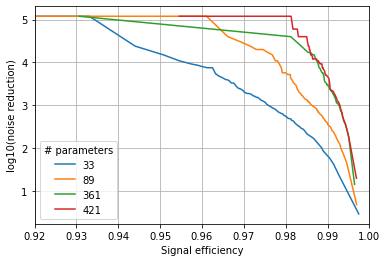

In [23]:
df = read_results("/content/gdrive/MyDrive/Colab Notebooks/result_1CH_100.csv")
for i in range(len(df)):
    plt.plot(df.iloc[i].ns, df.iloc[i].nr, label=df.iloc[i].Parameters)
plt.xlim((0.92, 1.0))
plt.xlabel("Signal efficiency")
plt.ylabel("log10(noise reduction)")
plt.grid()
plt.legend(title="# parameters")
plt.show()

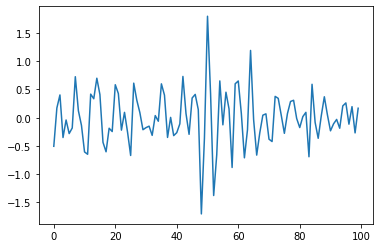

Logit output: [[-7.357095]]
True label: [[0.]]



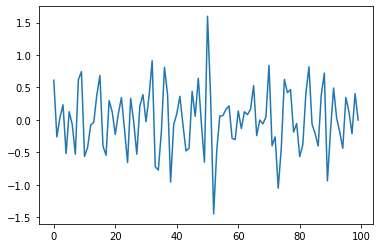

Logit output: [[-7.7483025]]
True label: [[0.]]



In [24]:
cl.plot_samples(n_samples=2)

### Test on a subset of ARIANNA 1CH 256 timesteps dataset

In [46]:
# Run the trained network on separate part of the ARIANNA 256 timesteps 1 channel dataset (batch mode)
path = "/content/gdrive/MyDrive/Colab Notebooks/Data/ARIANNA_256_1CH/"
noise_256 = np.load(path + "data_noise_1ch_3.6SNR_0005.npy")
for i in range(6,10):
    if i != 8:
        noise_256 = np.vstack((noise_256,np.load(path + f"data_noise_1ch_3.6SNR_000{i}.npy")))
signal_256 = np.load(path + "data_signal_1ch_0001.npy")
print("Signal events:", signal_256.shape)
print("Noise events:", noise_256.shape)

# Pruning to check if we get the same results
X_100 = signal_256[:, :, 0:100] 
Y_100 = noise_256[:, :, 0:100]

X_merge = np.concatenate((X_100, Y_100), axis=0)
y_merge = np.concatenate((np.ones(len(X_100)), np.zeros(len(Y_100))), axis=0)
print(X_merge.shape, y_merge.shape)
cl.set_test_set(pp.load_test_data(X_merge, y_merge))
cl.run_evaluation(batch_size=100)

Signal events: (21597, 1, 256)
Noise events: (400000, 1, 256)
(421597, 1, 100) (421597,)


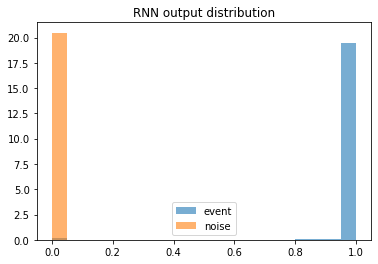

In [51]:
cl.plot_output_distribution()

Total signal events: 21597 Total noise events: 399903


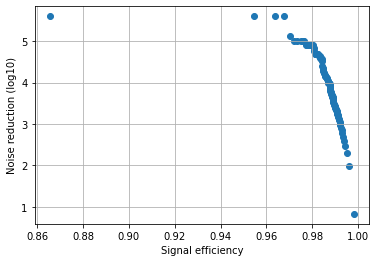

In [50]:
cl.plot_signal_eff_vs_noise_red()

## 3. Univariate continuous input (ARIANNA 100 1CH dataset)

### Data preparation (using data loaded previously in section 2) 

In [26]:
X_data, y_data = create_continuous_input(signal, noise, start_event=40, end_event=80)

Input shape: (99997, 1, 100) (600000, 1, 100)
Series size: 699997 1 100
Final shape of input and labels: (69999700, 1) (69999700,)


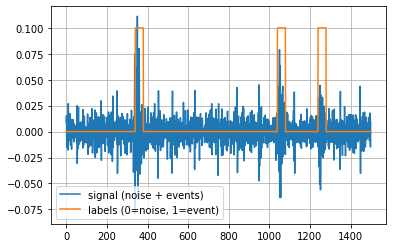

In [28]:
# Plot a random sample of the transformed data for visual verification
L = 1500
start = np.random.randint(len(X_data)-L)//100 * 100
plt.plot(X_data[start:start+L, 0], label="signal (noise + events)")
plt.plot(y_data[start:start+L]/10.0, label="labels (0=noise, 1=event)")
plt.legend()
plt.grid()
plt.show()

In [29]:
pp2 = BinaryClassificationPreprocessor()
SEQUENCE_LENGTH = 50000 # Number of timesteps of one item in one batch
WINDOW_LENGTH = 1  # This should always be 1 currently (i.e. we want to have one output value for each timestep)
d = pp2.load_continuous_data(X_data, y_data, SEQUENCE_LENGTH, WINDOW_LENGTH, test_ratio=0.2)

(1399, 1, 50000) (1399, 50000)
Before fit
After fit transform
1
2
After scaling
Preprocessed datasets:
Train: (839, 1, 50000), range [-434.84769364580194, 494.6508746384858]
Validation: (280, 1, 50000), range [-431.00411288941626, 435.93852631162224]
Test: (280, 1, 50000), range [-381.7718199205012, 440.3012618995794]


### Training

In [30]:
# The results will be accumulated in df
df = pd.DataFrame()

In [31]:
cl2 = RNNBinaryClassifier(device)
cl2.load_data(d)

In [32]:
model = Model_Continuous_LSTM(n_features, 1, 8, 2, dropout, device)
input = torch.randn(1, 100, 1).to(device)
macs, params = profile(model, inputs=(input, ))
print(macs)
print(params)

[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
106400.0
937.0


Number of trainable parameters in the model: 361
0...5...10...15...20...25...30...35...40...
[1/20] Training loss: 0.3067	 Validation loss: 0.2023
Best so far, saving
0...5...10...15...20...25...30...35...40...
[2/20] Training loss: 0.1656	 Validation loss: 0.1089
Best so far, saving
0...5...10...15...20...25...30...35...40...
[3/20] Training loss: 0.0933	 Validation loss: 0.0894
Best so far, saving
0...5...10...15...20...25...30...35...40...
[4/20] Training loss: 0.0878	 Validation loss: 0.0874
Best so far, saving
0...5...10...15...20...25...30...35...40...
[5/20] Training loss: 0.0860	 Validation loss: 0.0859
Best so far, saving
0...5...10...15...20...25...30...35...40...
[6/20] Training loss: 0.0848	 Validation loss: 0.0847
Best so far, saving
0...5...10...15...20...25...30...35...40...
[7/20] Training loss: 0.0836	 Validation loss: 0.0833
Best so far, saving
0...5...10...15...20...25...30...35...40...
[8/20] Training loss: 0.0813	 Validation loss: 0.0793
Best so far, saving
0...5..

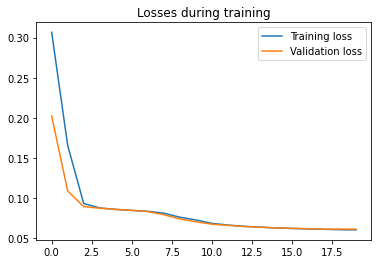

Training time: 156.24999809265137


In [33]:
n_features = 1  # Univariate
output_dim = 1  
hidden_size = 8
n_hidden = 1
dropout = 0.0

model2 = Model_Continuous_LSTM(n_features, 1, hidden_size, n_hidden, dropout, device)
print("Number of trainable parameters in the model:", sum(p.numel() for p in model2.parameters() if p.requires_grad))
t0 = time.time()
best_model2 = cl2.train(model2, n_features=n_features, n_epochs=20, lr=0.01, batch_size=20)  # Small batch size seems to work best here
print("Training time:", time.time() - t0)

### Evaluation

In [34]:
cl2.run_evaluation(batch_size=10)

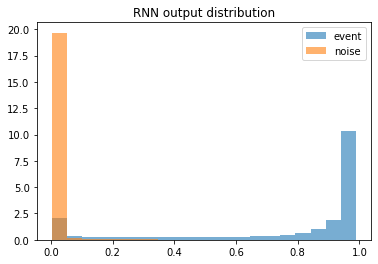

In [35]:
cl2.plot_output_distribution()

In [36]:
cl2.classify_with_threshold(r_value=0.5)

([0.9825321428571429,
  (0.9017867534099903, 0.7778459569341967, 0.8352435337045042, None)],
 array([False, False, False, ..., False, False, False]))

Total signal events: 796920 Total noise events: 13203080


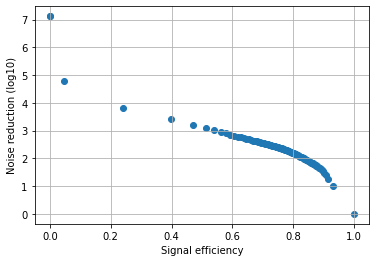

In [37]:
cl2.plot_signal_eff_vs_noise_red()

In [ ]:
#df = save_result(df, cl2)

Total signal events: 804560 Total noise events: 13195440


In [42]:
# Store the result for later use
filename = "/content/gdrive/MyDrive/Colab Notebooks/result_continuous_1CH_100.csv"
#df.to_csv(filename, index=False)
df = read_results(filename)

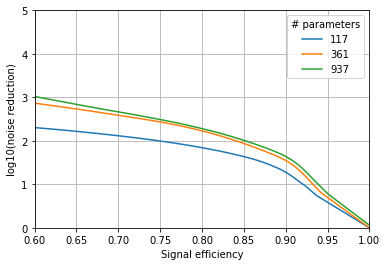

In [43]:
df = df.sort_values("Parameters")
for i in range(len(df)-1):
    plt.plot(df.iloc[i].ns, df.iloc[i].nr, label=df.iloc[i].Parameters)
plt.xlim((0.6, 1.0))
plt.ylim((0.0, 5.0))
plt.xlabel("Signal efficiency")
plt.ylabel("log10(noise reduction)")
plt.grid()
plt.legend(title="# parameters")
plt.show()

#### Classification of each 100-step sequence as either being a signal event or a noise event
This is done only for the purpose of comparing the results of continuous processing with the results from batch processing. 

In [44]:
def find_batch(loader, N, start):
    batch_length = N // len(loader)
    count = 0
    for x, y in loader:
        if count + batch_length < start:
            count += batch_length
        else:
            break   # Loop until we find the batch which the desired start index belongs to
    return count, x, y

In [47]:
def run_detection(y_pred, W, threshold):
    # Given the sigmoid step-by-step output from the RNN, apply a threshold to a running average
    # to determine whether we have found a signal event or not
    
    print("Running step-wise classification for", len(y_pred), "steps with threshold", threshold, ", width", W, "...")
    y_pred_avg = np.zeros(len(y_pred))
    for i in range(W, len(y_pred)):
        y_pred_avg[i] = np.mean(y_pred[i-W:i])

    return y_pred_avg > threshold

In [48]:
def plot_output_for_test_set(classifier, start, L, n_features=1):
    # start = from which timestep in the input sequence the plot should start (approximately)

    count, x, _ = find_batch(DataLoader(classifier.test_set, batch_size=1, shuffle=False), len(classifier.y_true), start)

    x_input = x.view([1, -1, n_features])[0,0:L,0].numpy()
    # x_input now contains (part of) the relevant part of the input
    y_pred = classifier.sigmoids[count:count+L]
    y_pred_avg = run_detection(y_pred, 3, 0.9)
    y_true = classifier.y_true[count:count+L]
    xs = np.linspace(0, L, num=L)
    
    w, h = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [20, 5]
    print("Starting at index", count)
    plt.plot(xs, x_input, alpha=0.5, label="input")
    plt.plot(xs, y_pred, label="sigmoid output")
    plt.plot(xs, y_true, label="labels")
    plt.plot(xs, y_pred_avg, label="result")
    plt.ylim((-1.5, 1.5))
    plt.xticks(np.arange(0,L,200))
    plt.grid()
    plt.legend()
    plt.show()
    plt.rcParams['figure.figsize'] = [w, h]

Running step-wise classification for 1000 steps with threshold 0.9 , width 3 ...
Starting at index 350000


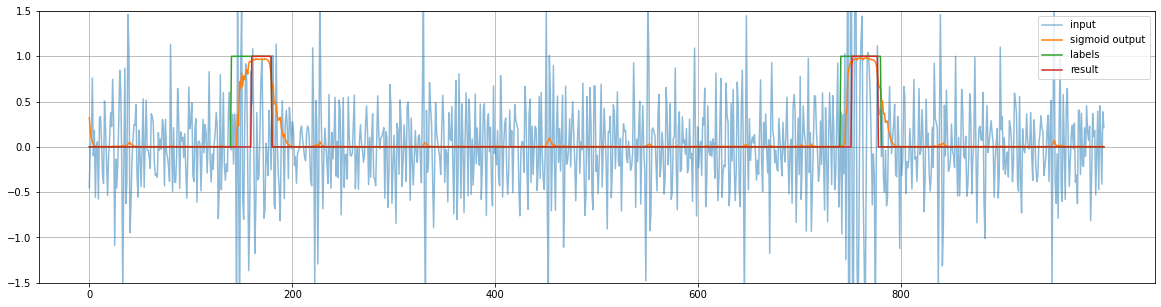

In [53]:
plot_output_for_test_set(cl2, np.random.randint(1000000), 1000)

In [ ]:
# Run the step-by-step detection using different thresholds, to get the signal efficiency vs noise reduction metric
# NOTE: this takes around one hour in Google Colab
thresholds = [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.95, 0.96, 0.97, 0.98]
widths = [5, 10, 15, 20, 30]
result_nr = []
result_ns = []
for i in range(len(thresholds)):
  for w in widths:
    
    # Calculate metrics based on detecting continously and classifying each of the original 100-timestep batches in the test dataset
    y_pred_steps = run_detection(cl2.sigmoids, w, thresholds[i])

    N_WINDOWS = len(y_pred_steps)//100
    print(N_WINDOWS)
    y_true = np.zeros(N_WINDOWS)
    y_pred = np.zeros(N_WINDOWS)
    for window in range(N_WINDOWS):
        start = window * 100
        end = start + 100
        y_true[window] = cl2.y_true[start + 50]
        if y_true[window]:
            # If this is a signal event window, the detection has to be within step 40 to 80 
            y_pred[window] = np.sum(y_pred_steps[start+40:end-20]) > 0.0
        else:
            # If this is a noise event window, it is a false positive if any detection happens within the entire window 
            y_pred[window] = np.sum(y_pred_steps[start:end]) > 0.0
    
    tp = np.sum((y_pred == True) & (y_true == True))
    fp = np.sum((y_pred == True) & (y_true == False))
    tn = np.sum((y_pred == False) & (y_true == False))
    fn = np.sum((y_pred == False) & (y_true == True))
    print(tp, fp, tn, fn)
    ns = tp/(tp + fn)
    if tn/(tn + fp) < 1.0:
        nr = np.log10(1/(1-tn/(tn + fp)))
    else:
        nr = np.log10(tn + fp)
    print("Signal eff.:", ns)
    print("Noise red.:", nr)

    result_ns.append(ns)
    result_nr.append(nr)

Running step-wise classification for 14000000 steps with threshold 0.2 , width 5 ...
140000
19694 1798 118278 230
Signal eff.: 0.9884561333065649
Noise red.: 1.8246665247588743
Running step-wise classification for 14000000 steps with threshold 0.2 , width 10 ...
140000
19670 1026 119050 254
Signal eff.: 0.9872515559124674
Noise red.: 2.0683088513802894
Running step-wise classification for 14000000 steps with threshold 0.2 , width 15 ...
140000
19650 1344 118732 274
Signal eff.: 0.986247741417386
Noise red.: 1.9510569434382756
Running step-wise classification for 14000000 steps with threshold 0.2 , width 20 ...
140000
19633 4451 115625 291
Signal eff.: 0.985394499096567
Noise red.: 1.430998617873561
Running step-wise classification for 14000000 steps with threshold 0.2 , width 30 ...
140000
19611 13207 106869 313
Signal eff.: 0.9842903031519775
Noise red.: 0.9586520343152866
Running step-wise classification for 14000000 steps with threshold 0.4 , width 5 ...
140000
19597 291 119785 327


In [ ]:
df_res = pd.DataFrame()
df2 = pd.DataFrame()
df2['threshold'] = thresholds * len(widths)
df2['width'] = widths * len(thresholds)
df2['ns'] = result_ns
df2['nr'] = result_nr
df_res = pd.concat([df_res, df2])
df_res = df_res.sort_values(['ns'])
df_res

,threshold,width,ns,nr
54,0.98,30,0.000100,5.079456
49,0.80,30,0.055662,5.079456
44,0.20,30,0.216874,4.778426
53,0.97,20,0.341146,5.079456
39,0.85,30,0.408904,4.778426
52,0.96,15,0.645603,5.079456
48,0.70,20,0.733788,4.602335
51,0.95,10,0.739861,5.079456
50,0.85,5,0.801445,4.778426
47,0.60,15,0.817808,4.602335


In [40]:
# Store the results for later use
filename = "/content/gdrive/MyDrive/Colab Notebooks/result_1CH_100_continuous_threshold_width_params361.csv"
#df_res.to_csv(filename, index=False)
df_res = pd.read_csv(filename)

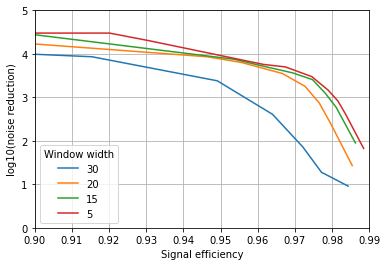

In [41]:
for w in [30, 20, 15, 5]:
    plt.plot(df_res[df_res.width==w].ns, df_res[df_res.width==w].nr, label=str(w))
    plt.xlabel("Signal efficiency")
    plt.ylabel("log10(noise reduction)")
plt.xlim((0.9, 0.99))
plt.ylim((0.0, 5.0))
plt.grid()
plt.legend(title="Window width")
plt.show()

0.7340478897094727 microseconds per time step


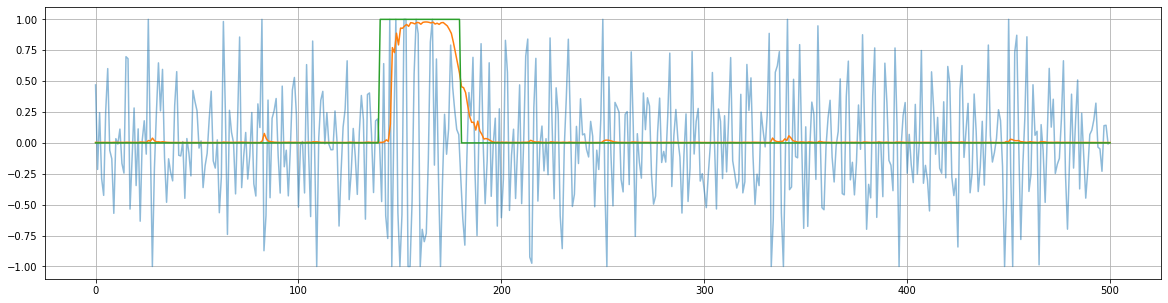

0.8510303497314453 microseconds per time step


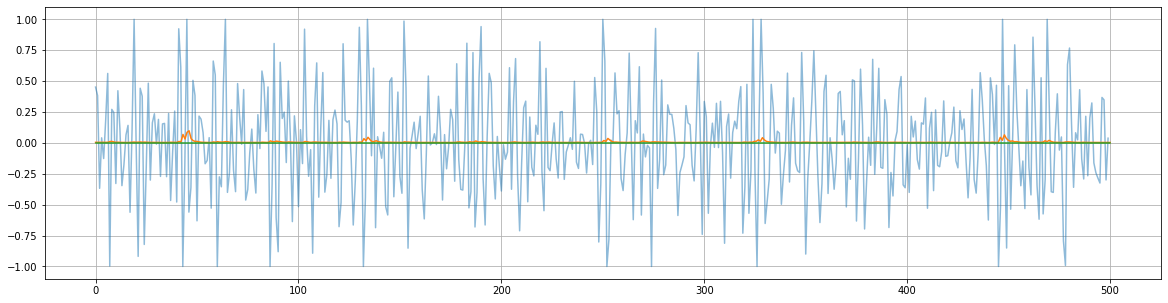

0.8432483673095703 microseconds per time step


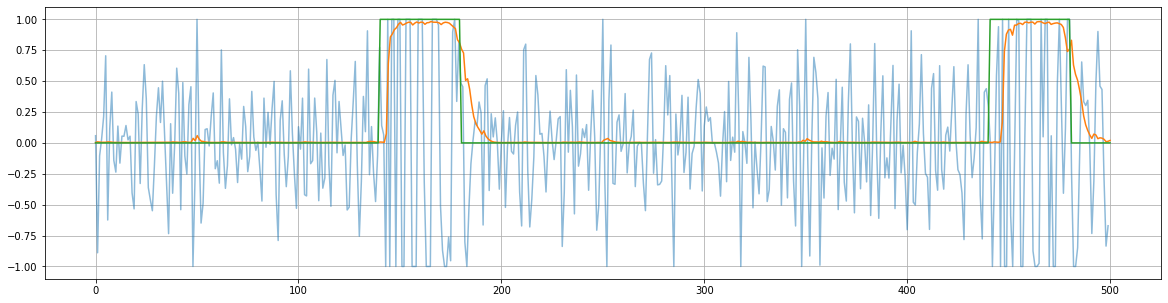

0.9404087066650391 microseconds per time step


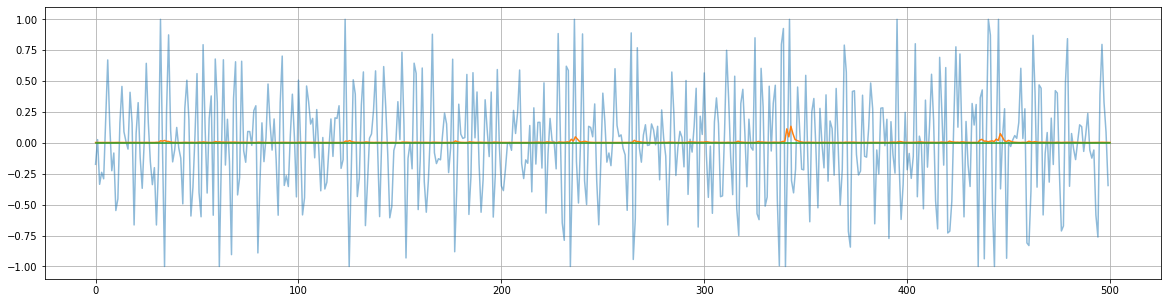

0.9312057495117188 microseconds per time step


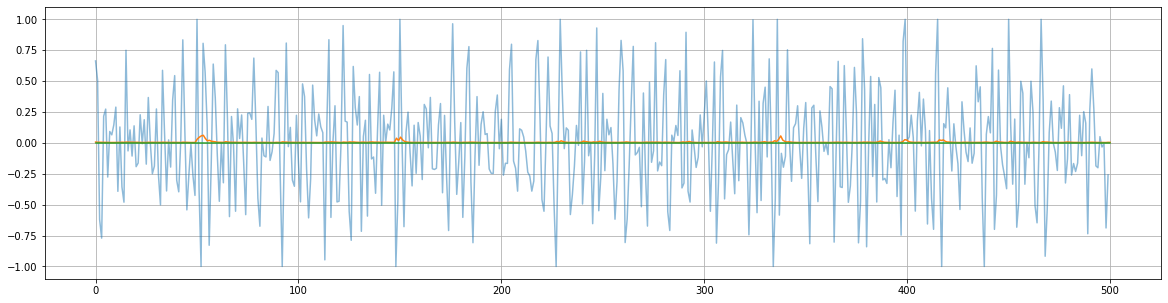

In [54]:
# Select some random examples, classify and show the signal for visual verification
dl = DataLoader(cl2.test_set, batch_size=1, shuffle=True)
r_value = 0.5
count = 0
start = 5100
L = 500
output_start = start // WINDOW_LENGTH
output_length = L // WINDOW_LENGTH 

w, h = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]

for x, y in dl:
    x_input = x.view([1, -1, n_features]).to(device)
    t0 = time.time()
    logit = best_model2(x_input)  # Here the number of outputs is equal to SEQUENCE_LENGTH // WINDOW_LENGTH
    print((time.time() - t0)*1e6/x_input.size()[1], "microseconds per time step")
    y_pred = torch.sigmoid(logit[0,output_start:output_start+output_length,0]).detach().cpu().numpy()
    y_true = y[0,output_start:output_start+output_length,0].detach().cpu().numpy()
    input = x_input[0,start:start+L,0].detach().cpu().numpy()
    plt.plot(input.clip(-1.0, 1.0), alpha=0.5)
    plt.plot(np.linspace(0, L, num=output_length), y_pred)
    plt.plot(np.linspace(0, L, num=output_length), y_true)
    plt.grid()
    plt.show()
    count += 1
    if count > 4:
        break
plt.rcParams['figure.figsize'] = [w, h]

290.9226417541504 microseconds per time step
7 0 0


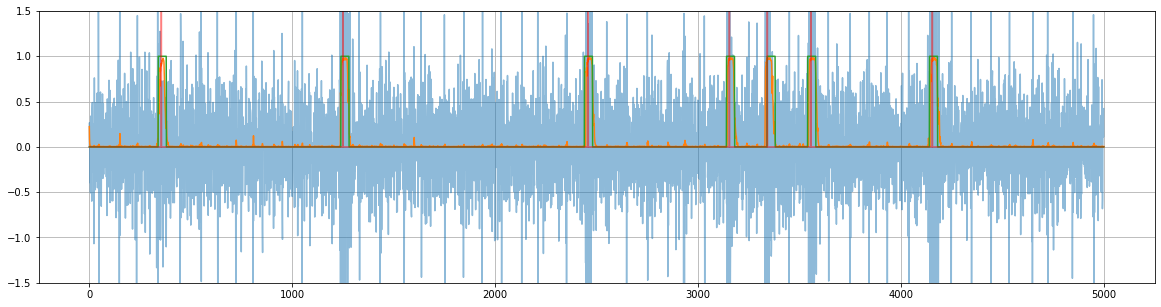

In [57]:
# Run on a continuous signal (test data)
dl = DataLoader(cl2.test_set, shuffle=True)
X, y = next(iter(dl))    # Get one random series of SEQUENCE_LENGTH time steps
n_features = 1
start = 0000
L = 5000
y_pred = np.zeros(L//WINDOW_LENGTH)
detected = np.zeros(L//WINDOW_LENGTH)
y_true = y[0,start//WINDOW_LENGTH:(start+L)//WINDOW_LENGTH,0].detach().cpu().numpy()
best_model2.step_by_step_mode(True)
t0 = time.time()
width = 0.0
deadtime = 0
tp = 0
fp = 0
fn = 0
errors = []
signal_event = False
for w in range(L//WINDOW_LENGTH):  # Run in "batches" of length WINDOW_LENGTH
    x0 = start + w * WINDOW_LENGTH # First timestep of input for this window
    x1 = x0 + WINDOW_LENGTH        # Last timestep of input for this window
    s = torch.sigmoid(best_model2(X[0, :, x0:x1].view([1,-1,n_features]).to(device)))
    y_pred[w] = s

    if y_true[w]:
        signal_event = True
    elif signal_event == True:  # If we are leaving a part where the label is "true"
        signal_event = False
        if deadtime > 0:
            tp += 1     # Ok, successful detection for the current label
        else:
            fn += 1     # No deadtime currently: we did not detect this signal event
            #print("fn at", w)
            errors.append(w)

    if deadtime > 0:   # No detection during deadtime
        deadtime -= 1   
    else:
                
        if y_pred[w] > 0.6:
            width += 1.0
        else:
            width = 0.0
        if width > 10//WINDOW_LENGTH:           # Signal event detected!
            detected[w] = 1.5
            if not y_true[w]:   # Do we have a "true" label at this timestep? 
                fp += 1
                #print("fp at", w)
                errors.append(w)
            width = 0.0
            deadtime = 50//WINDOW_LENGTH

print((time.time() - t0)*1e6/L, "microseconds per time step")
print(tp, fp, fn)
input = X[0][0][start:start+L].detach().cpu().numpy()  ## NOTE: Only one feature is shown
w, h = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(input, alpha=0.5)
xs = np.linspace(0, L, num=L//WINDOW_LENGTH)
plt.plot(xs, y_pred)
plt.plot(xs, y_true)
plt.plot(xs, detected, c='r', alpha=0.5)
plt.ylim((-1.5, 1.5))
plt.grid()
plt.show()

# Plot the input and output around the timesteps where misclassification occurs
width = 100 // WINDOW_LENGTH
for e in errors:
    
    x0 = (start + (e-width) * WINDOW_LENGTH) // 100 * 100  # Ensure we start from the beginning of one of the original sequences
    x1 = (start + (e+width) * WINDOW_LENGTH) // 100 * 100
    y0 = x0 // WINDOW_LENGTH
    y1 = x1 // WINDOW_LENGTH

    print("Showing input from", x0, "to", x1, "and output from", y0, "to", y1)
    input = X[0][0][x0:x1].detach().cpu().numpy()  # NOTE: Only one feature is shown
    w, h = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot(input, alpha=0.5)
    xs = np.linspace(0, x1 - x0, num=2*width)
    plt.plot(xs, y_pred[y0:y1])
    plt.plot(xs, y_true[y0:y1])
    plt.plot(xs, detected[y0:y1], c='r', alpha=0.5)
    plt.ylim((-1.5, 1.5))
    plt.grid()
    plt.show()


plt.rcParams['figure.figsize'] = [w, h]

## 4. Multivariate input (5 channels), batch mode (ARIANNA 256 5CH dataset)

### Data preparation

In [11]:
# Load ARIANNA 5 channels dataset
path = data_path + "ARIANNA_256_5CH/"
noise_5ch = np.load(path + "data_noise_5ch_3.6SNR_0000.npy")
for i in range(1, 9):
    print(i, end=", ")
    noise_5ch = np.vstack((noise_5ch, np.load(path + f"data_noise_5ch_3.6SNR_000{i}.npy")))
events_5ch = np.load(path + "data_signal_5ch_0000.npy")
events_5ch = np.vstack((events_5ch, np.load(path + "data_signal_5ch_0001.npy")))
print()
print("Original data:", events_5ch.shape, noise_5ch.shape)
events_5ch = events_5ch[:,:,20:120]
noise_5ch = noise_5ch[:,:,20:120]
print("After pruning:", events_5ch.shape, noise_5ch.shape)

1, 2, 3, 4, 5, 6, 7, 8, 
Original data: (121597, 5, 256) (900000, 5, 256)
After pruning: (121597, 5, 100) (900000, 5, 100)


In [12]:
print("Total number of invalid values (nan) in the dataset:", np.sum(np.isnan(events_5ch)))

Total number of invalid values (nan) in the dataset: 500


In [13]:
# Remove series with nan values
nan_series = np.isnan(np.sum(np.sum(events_5ch, axis=2), axis=1))
events_5ch = events_5ch[nan_series == False]
events_5ch.shape

(121592, 5, 100)

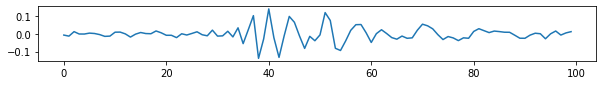

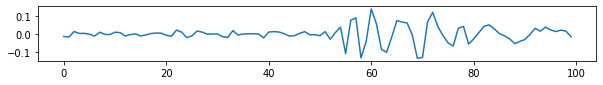

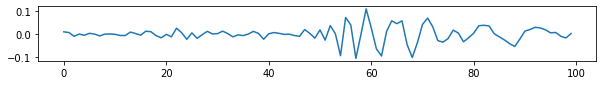

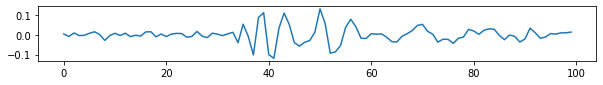

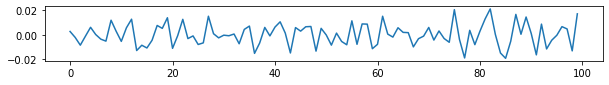

In [14]:
w, h = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 1]
for i in range(5):
  plt.plot(events_5ch[10081][i])
  plt.show()
plt.rcParams['figure.figsize'] = [w, h]

In [15]:
pp5 = BinaryClassificationPreprocessor()
cl5 = RNNBinaryClassifier(device)

In [16]:
cl5.load_data(pp5.load_data_by_class(events_5ch, noise_5ch, val_ratio=0.2, test_ratio=0.2))

Process 1: using 121592 time series with 5 features, of length 100
Process 2: using 900000 time series with 5 features, of length 100
Before fit
After fit transform
1
2
After scaling
Preprocessed datasets:
Train: (612954, 5, 100), range [-655.3907204497771, 544.4388841990823]
Validation: (204319, 5, 100), range [-486.15174686890765, 513.8041333301904]
Test: (204319, 5, 100), range [-496.7753144501502, 361.4467096364672]


### Training


Number of trainable parameters in the model: 93
0...613...1226...1839...2452...3065...3678...4291...4904...5517...
[1/10] Training loss: 0.0893	 Validation loss: 0.0235
Best so far, saving
0...613...1226...1839...2452...3065...3678...4291...4904...5517...
[2/10] Training loss: 0.0162	 Validation loss: 0.0115
Best so far, saving
0...613...1226...1839...2452...3065...3678...4291...4904...5517...
[3/10] Training loss: 0.0121	 Validation loss: 0.0101
Best so far, saving
0...613...1226...1839...2452...3065...3678...4291...4904...5517...
[4/10] Training loss: 0.0114	 Validation loss: 0.0094
Best so far, saving
0...613...1226...1839...2452...3065...3678...4291...4904...5517...
[5/10] Training loss: 0.0106	 Validation loss: 0.0084
Best so far, saving
0...613...1226...1839...2452...3065...3678...4291...4904...5517...
[6/10] Training loss: 0.0095	 Validation loss: 0.0077
Best so far, saving
0...613...1226...1839...2452...3065...3678...4291...4904...5517...
[7/10] Training loss: 0.0089	 Validati

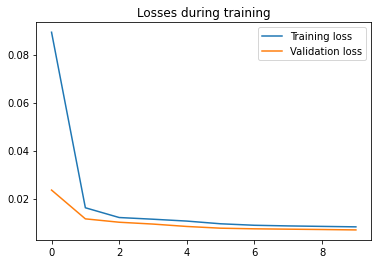

Training time: 238.2178566455841


In [83]:
n_features = 5
output_dim = 1  
hidden_size = 2
n_hidden = 2
dropout = 0.0

model = Model_GRU(n_features, 1, hidden_size, n_hidden, dropout, device)
print("\nNumber of trainable parameters in the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))
t0 = time.time()
best_model = cl5.train(model, n_features=n_features, n_epochs=10, lr=0.002, batch_size=100)
print("Training time:", time.time() - t0)

### Evaluation

In [84]:
cl5.run_evaluation()

In [85]:
cl5.classify_with_threshold(r_value=0.5)

([0.9978316201664219,
  (0.99644921552436, 0.985423216691846, 0.9909055449487796, None)],
 array([False, False, False, ..., False, False, False]))

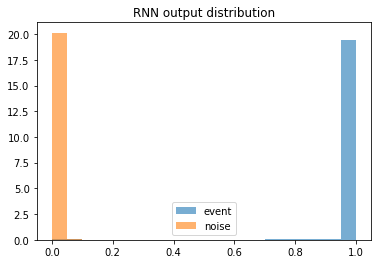

In [86]:
cl5.plot_output_distribution()

Total signal events: 24491 Total noise events: 179809


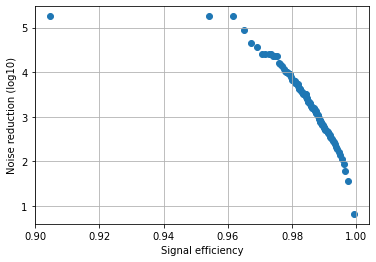

In [87]:
cl5.plot_signal_eff_vs_noise_red()

In [88]:
# Accumulate results for plotting
#df = pd.DataFrame()
df = save_result(df, cl5)

Total signal events: 24491 Total noise events: 179809


In [93]:
# Store the accumulated results for later use
filename = "/content/gdrive/MyDrive/Colab Notebooks/result_5CH_100.csv"
#df.to_csv(filename, index=False)
#df = read_results(filename)

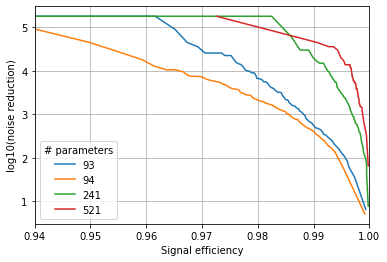

In [91]:
plot_results_comparison(df.sort_values('Parameters'), (0.94, 1.00), None)

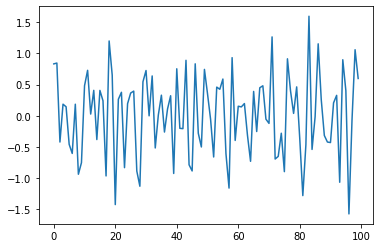

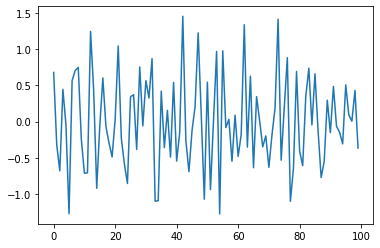

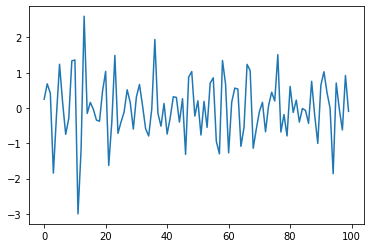

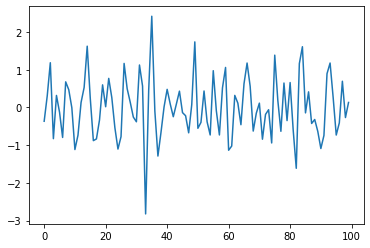

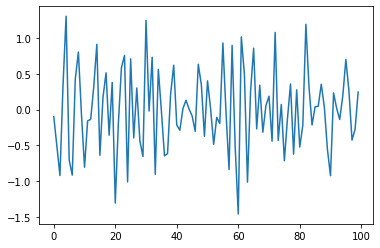

Logit output: [[-10.53583]]
True label: [[0.]]



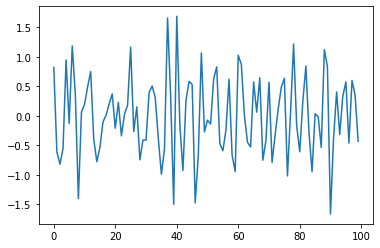

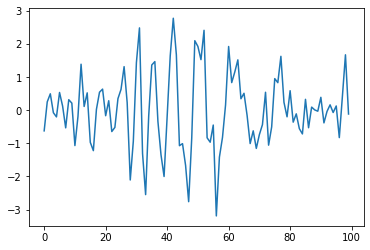

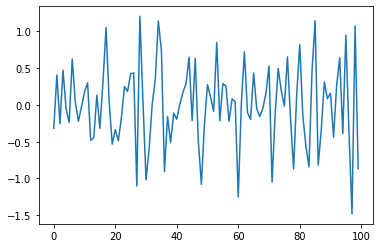

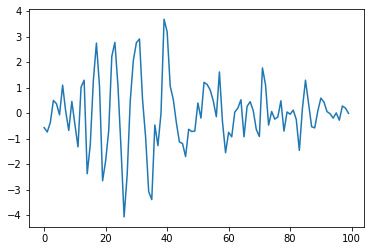

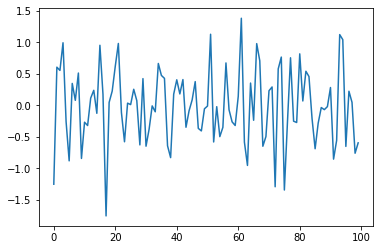

Logit output: [[9.391252]]
True label: [[1.]]



In [56]:
cl5.plot_samples(n_samples=2)

## 5. Multivariate continuous processing (ARIANNA 5CH 256 dataset)

In [ ]:
X_data, y_data = create_continuous_input(events_5ch, noise_5ch, start_event=30, end_event=80)

Input shape: (99995, 5, 100) (500000, 5, 100)
Series size: 599995 5 100
Final shape of input and labels: (59999500, 5) (59999500,)


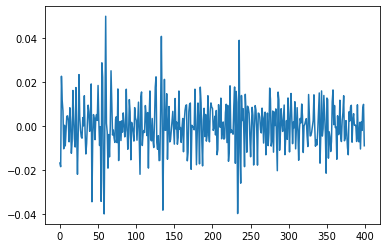

In [ ]:
plt.plot(X_data[100:500,4])
plt.show()

In [ ]:
pp5c = BinaryClassificationPreprocessor()
cl5c = RNNBinaryClassifier(device)

In [ ]:
SEQUENCE_LENGTH = 50000
WINDOW_LENGTH = 1
d = pp5c.load_continuous_data(X_data, y_data, SEQUENCE_LENGTH, WINDOW_LENGTH, test_ratio=0.2)

(1199, 5, 50000) (1199, 50000)
Before fit
After fit transform
1
2
After scaling
Preprocessed datasets:
Train: (719, 5, 50000), range [-457.1695818717634, 362.6758426731974]
Validation: (240, 5, 50000), range [-278.6283544698512, 297.5600686724502]
Test: (240, 5, 50000), range [-287.7083562767148, 234.0940649814193]


In [ ]:
cl5c.load_data(d)


Number of trainable parameters in the model: 1065
0...4...8...12...16...20...24...28...32...
[1/10] Training loss: 0.6835	 Validation loss: 0.5742
Best so far, saving
0...4...8...12...16...20...24...28...32...
[2/10] Training loss: 0.4423	 Validation loss: 0.3263
Best so far, saving
0...4...8...12...16...20...24...28...32...
[3/10] Training loss: 0.2994	 Validation loss: 0.2884
Best so far, saving
0...4...8...12...16...20...24...28...32...
[4/10] Training loss: 0.2871	 Validation loss: 0.2873
Best so far, saving
0...4...8...12...16...20...24...28...32...
[5/10] Training loss: 0.2869	 Validation loss: 0.2873
Best so far, saving
0...4...8...12...16...20...24...28...32...
[6/10] Training loss: 0.2869	 Validation loss: 0.2873
Best so far, saving
0...4...8...12...16...20...24...28...32...
[7/10] Training loss: 0.2869	 Validation loss: 0.2873
Best so far, saving
0...4...8...12...16...20...24...28...32...
[8/10] Training loss: 0.2869	 Validation loss: 0.2873
Best so far, saving
0...4...8...1

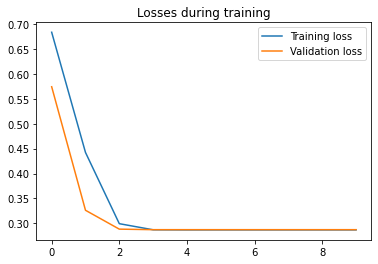

Training time: 86.40629816055298


In [ ]:
n_features = 5
output_dim = 1  
hidden_size = 8
n_hidden = 2
dropout = 0.0

model = Model_Continuous_LSTM(n_features, 1, hidden_size, n_hidden, dropout, device)
print("\nNumber of trainable parameters in the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))
t0 = time.time()
best_model = cl5c.train(model, n_features=n_features, n_epochs=10, lr=0.002, batch_size=20)
print("Training time:", time.time() - t0)

In [ ]:
cl5c.run_evaluation()

In [ ]:
cl5c.classify_with_threshold(r_value=0.5)

([0.9634566,
  (0.7359909372319398, 0.7077813975730767, 0.7216105775090808, None)],
 array([False, False, False, ..., False, False, False]))

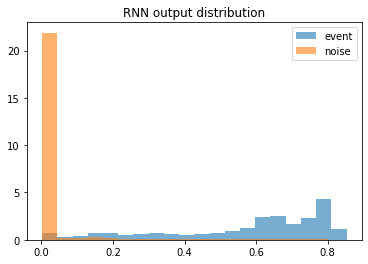

In [ ]:
cl5c.plot_output_distribution()

Total signal events: 669160 Total noise events: 9330840


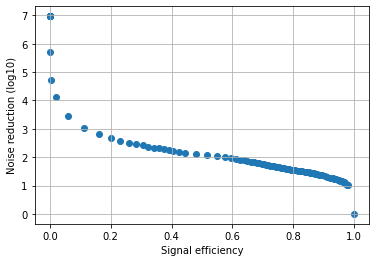

In [ ]:
cl5c.plot_signal_eff_vs_noise_red()

In [ ]:
df = pd.DataFrame()
df = save_result(df, cl5c)

Total signal events: 669160 Total noise events: 9330840


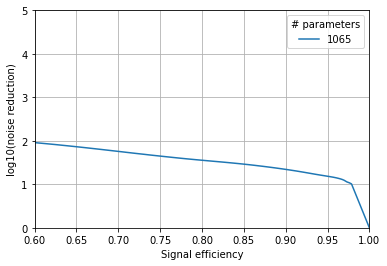

In [ ]:
plot_results_comparison(df, (0.6, 1.0), (0.0,5.0))

## 6. <b>NOT FINISHED</b>: Multivariate batch processing (experimenting with a new dataset from Alan)

In [ ]:
path = "/content/gdrive/MyDrive/Colab Notebooks/Data/ALAN_4CH/"
noise = np.load(path + "noise/SNR_4.5-Vrms_0.01-fLow_0.08-fhigh_0.5-rate_2.0-mult_2-File_0002.npy")
energies = ["16.00eV", "16.25eV", "16.50eV", "16.75eV", "17.00eV", "17.25eV", "17.50eV", "17.75eV" ,"18.00eV", "18.25eV", "18.50eV", "18.75eV", "19.00eV"]
signal = np.load(path + "signals/" + energies[0] +"/Waveforms.npz")['arr_0']
labels = np.load(path + "signals/" + energies[0] +"/Labels.npz")['arr_0']
for i in range(1, len(energies)-6):
    print(energies[i], end=", ")
    signal = np.vstack((signal, np.load(path + "signals/" + energies[i] + "/Waveforms.npz")['arr_0']))
    labels = np.vstack((labels, np.load(path + "signals/" + energies[i] + "/Labels.npz")['arr_0']))
print()
print("Signal data:", signal.shape)
print("Label data:", labels.shape)
print("Noise data:", noise.shape)

16.25eV, 16.50eV, 16.75eV, 17.00eV, 17.25eV, 17.50eV, 
Signal data: (16421, 4, 4096)
Label data: (16421, 4, 4096)
Noise data: (3334, 4, 10000)


In [ ]:
# Remove series with nan values
nan_series = np.isnan(np.sum(np.sum(signal, axis=2), axis=1))
signal = signal[nan_series == False]
labels = labels[nan_series == False]
signal.shape, labels.shape

((16420, 4, 4096), (16420, 4, 4096))

In [ ]:
# Rescale (according to instructions from Alan)
rms_noise = 0.01
rms_signal = 9.334477730318125e-06
noise = noise * rms_signal / rms_noise

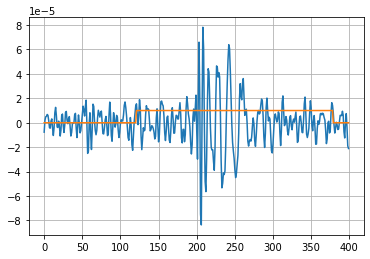

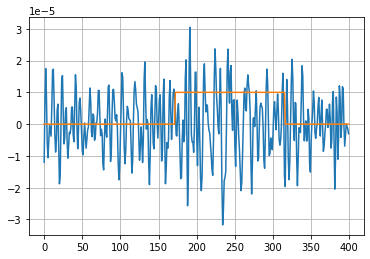

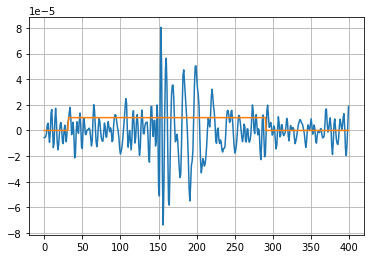

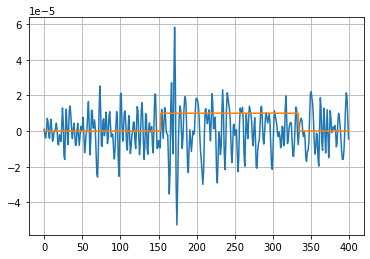

In [ ]:
for c in range(0,4):
  plt.plot(signal[int(74431/4096),c,700:1100])
  plt.plot(labels[int(74431/4096),c,700:1100]/1e5)
  plt.grid()
  plt.show()

In [ ]:
signal[0, 0, 1]

-5.791366733152861e-06

In [ ]:
# Create labels that are guaranteed to span an entire event
N_STEPS = signal.shape[0] * signal.shape[2] #+ noise.shape[0] * noise.shape[2]
N_FEATURES = signal.shape[1]
labels_list = []
for i in range(len(labels)):
    common_labels = np.sum(labels[i], axis=0)       # Will be 1 if any of the separate channel labels is 1
    union_labels = np.zeros_like(common_labels)
    # Handle gaps, i.e., make sure we have a contiguous sequence of 1:s
    union_labels[min(np.where(common_labels > 0)[0]):max(np.where(common_labels > 0)[0])] += 1  
    labels_list.append(union_labels)
print("Ratio of ones in contiguous set:", np.sum(labels_list)/N_STEPS, "and in set with possible gaps:", np.sum(labels)/4.0/N_STEPS)

Ratio of ones in contiguous set: 0.041284283766938185 and in set with possible gaps: 0.027968635512617995


In [ ]:
# Create a continuous sequence by concatenating (mixing) noise and signal data sequences randomly
print("Creating a sequence of", N_STEPS, "time steps with", N_FEATURES, "features")
seq_list = []
for i in range(len(signal)):
  seq_list.append(signal[i])   # Labels for the signal events were created above
#for i in range(len(noise)):
#  seq_list.append(noise[i])
#  labels_list.append(np.zeros(noise.shape[2]))  # Create labels for the noise parts

X_data = np.zeros((N_STEPS, N_FEATURES))
y_data = np.zeros(N_STEPS)
p = np.random.permutation(len(seq_list))
pos = 0
for i in range(len(seq_list)):
      j = i ### p[i]   # Random order when concatenating
      L = seq_list[j].shape[1]  # Length of subsequence
      #print(L, end=", ")
      for ch in range(N_FEATURES):
          X_data[pos:pos+L, ch] = seq_list[j][ch]
      y_data[pos:pos+L] = labels_list[j].reshape(L)
      pos += L
      
print("Final shape of input and labels:", X_data.shape, y_data.shape)

Creating a sequence of 67256320 time steps with 4 features
4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096,

74431


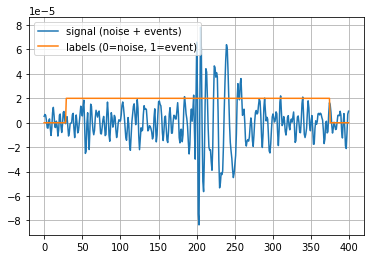

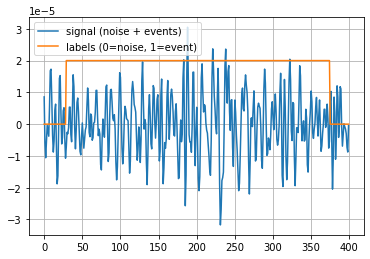

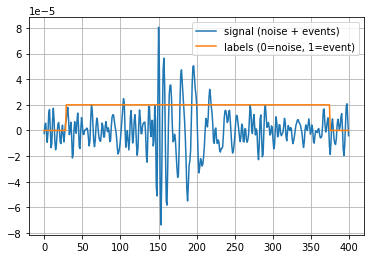

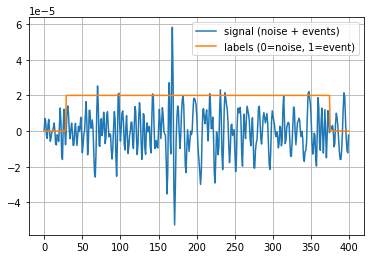

In [ ]:
# Plot a random sample of the transformed data for visual verification
L = 400
start = np.random.randint(len(X_data)-L)//100 * 100
start = np.where(X_data[:,0] > 5e-5)[0][0] - 200
#start = 700
print(start)
for c in range(0,4):
    plt.plot(X_data[start:start+L, c], label="signal (noise + events)")
    plt.plot(y_data[start:start+L]/0.5e5, label="labels (0=noise, 1=event)")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
pp4c = BinaryClassificationPreprocessor()
cl4c = RNNBinaryClassifier(device)

In [ ]:
SEQUENCE_LENGTH = 50000
WINDOW_LENGTH = 1
d = pp4c.load_continuous_data(X_data, y_data, SEQUENCE_LENGTH, WINDOW_LENGTH, test_ratio=0.2)

(1345, 4, 50000) (1345, 50000)
Before fit
After fit transform
1
2
After scaling
Preprocessed datasets:
Train: (807, 4, 50000), range [-131.5889417495092, 175.13517259837957]
Validation: (269, 4, 50000), range [-83.2751805780353, 58.07809474643991]
Test: (269, 4, 50000), range [-83.5079948243529, 89.03400225047528]


In [ ]:
cl4c.load_data(d)

In [ ]:
n_features = 4
output_dim = 1  
hidden_size = 6
n_hidden = 2
dropout = 0.1

model = Model_Continuous_LSTM(n_features, 1, hidden_size, n_hidden, dropout, device)
print("\nNumber of trainable parameters in the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))
t0 = time.time()
best_model = cl4c.train(model, n_features=n_features, n_epochs=10, lr=0.002, batch_size=10)
print("Training time:", time.time() - t0)


Number of trainable parameters in the model: 631
0...9...18...27...36...45...54...63...72...
[1/10] Training loss: 0.4591	 Validation loss: 0.2748
Best so far, saving
0...9...18...27...36...45...54...63...72...
[2/10] Training loss: 0.2102	 Validation loss: 0.1820
Best so far, saving
0...9...18...27...36...45...54...63...72...
[3/10] Training loss: 0.1764	 Validation loss: 0.1744
Best so far, saving
0...9...18...27...36...45...54...63...72...
[4/10] Training loss: 0.1728	 Validation loss: 0.1732
Best so far, saving
0...9...18...27...36...45...54...63...72...
[5/10] Training loss: 0.1722	 Validation loss: 0.1730
Best so far, saving
0...9...18...

KeyboardInterrupt: ignored

In [ ]:
cl4c.run_evaluation()
cl4c.classify_with_threshold(r_value=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


([0.9592543, (0.0, 0.0, 0.0, None)],
 array([False, False, False, ..., False, False, False]))

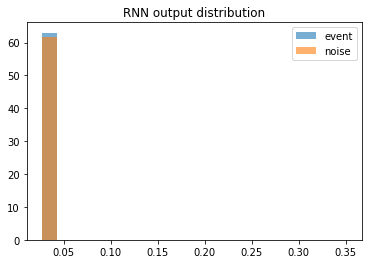

In [ ]:
cl4c.plot_output_distribution()

Total signal events: 46767 Total noise events: 4953233


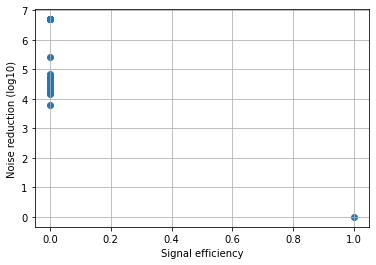

In [ ]:
cl4c.plot_signal_eff_vs_noise_red()

Starting at index 74348


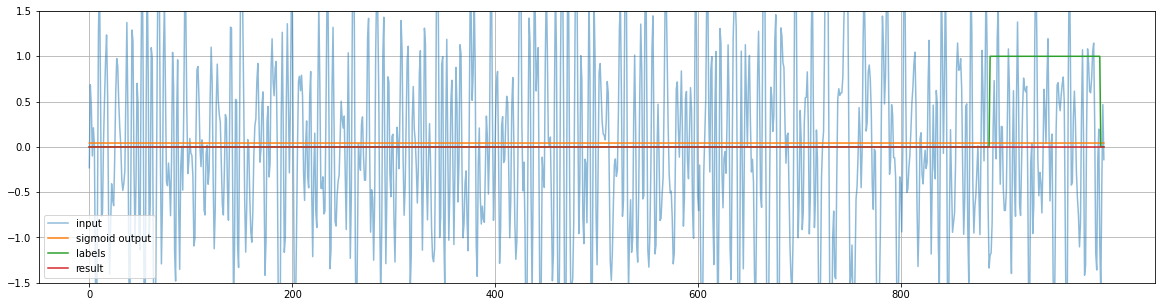

In [ ]:
plot_output_for_test_set(cl4c, 100000, 1000, n_features=1)